# Steiner tree for "all actomyosins" and integrins

In [ ]:
# Prerequisites: install Omics Integrator from https://github.com/fraenkel-lab/OmicsIntegrator2

In [1]:
import networkx as nx
import OmicsIntegrator as oi
import matplotlib.pyplot as plt
import pandas as pd
import collections
import scipy as sp

In [2]:
import pandas as pd
import collections
import scipy as sp
go_all = pd.read_csv("goa_human.gaf", comment = "!", sep="\t", header=None, names = ["DB", "DBID", "DBSymbol", "Qualifier",
                                                                                     "GOID", "DB:Ref", "EvidenceCode", "WithOrFrom",
                                                                                    "Aspect", "DBName", "DBSynonym", "DBType",
                                                                                    "Taxon", "Date", "AssignedBy", "AnnEXt",
                                                                                    "ProductID"])

/home/yasirs/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
go_all.loc[1:6]

,DB,DBID,DBSymbol,Qualifier,GOID,DB:Ref,EvidenceCode,WithOrFrom,Aspect,DBName,DBSynonym,DBType,Taxon,Date,AssignedBy,AnnEXt,ProductID
1,UniProtKB,A0A024RBG1,NUDT4B,NaN,GO:0005829,GO_REF:0000052,IDA,NaN,C,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,protein,taxon:9606,20161204,HPA,NaN,NaN
2,UniProtKB,A0A024RBG1,NUDT4B,NaN,GO:0008486,GO_REF:0000003,IEA,EC:3.6.1.52,F,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,protein,taxon:9606,20190601,UniProt,NaN,NaN
3,UniProtKB,A0A024RBG1,NUDT4B,NaN,GO:0046872,GO_REF:0000037,IEA,UniProtKB-KW:KW-0479,F,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,protein,taxon:9606,20190601,UniProt,NaN,NaN
4,UniProtKB,A0A024RBG1,NUDT4B,NaN,GO:0052840,GO_REF:0000003,IEA,EC:3.6.1.52,F,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,protein,taxon:9606,20190601,UniProt,NaN,NaN
5,UniProtKB,A0A024RBG1,NUDT4B,NaN,GO:0052842,GO_REF:0000003,IEA,EC:3.6.1.52,F,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,protein,taxon:9606,20190601,UniProt,NaN,NaN
6,UniProtKB,A0A075B6H9,IGLV4-69,NaN,GO:0002250,GO_REF:0000037,IEA,UniProtKB-KW:KW-1064,P,Immunoglobulin lambda variable 4-69,IGLV4-69,protein,taxon:9606,20190601,UniProt,NaN,NaN


In [10]:
actomyosin_org = go_all.loc[go_all["GOID"]=="GO:0003723"].loc[go_all["EvidenceCode"].isin(["EXP","IDA","IPI","IGI","IEP"])].loc[:,"DBSymbol"].unique()

In [20]:
all_actomyosin = actomyosin_org.tolist()
integrins = ["ITGA11", "ITGA8",  "ITGAV",  "ITGA1",  "ITGA10"]
go_diff = pd.read_table(filepath_or_buffer="Cardiac_muscle_cell_diff.txt", header=None)

In [15]:
# Read differential regulation data
DEdata = pd.read_csv(filepath_or_buffer="../outData/allres30.txt", sep="\t", header=0)
# Remove rows with no F30 to N30 data
DEdata.drop(DEdata[DEdata["zscore.N30_F30"].isna()].index, inplace=True)
# Remove duplicated genes
DEdata.drop(DEdata.loc[list(map(lambda x:x[0], filter(lambda x:x[1]>1,collections.Counter(DEdata.index.values).items())))].index, inplace=True)
DEdata.set_index("hgnc_symbol", inplace=True)

In [122]:
use_beta = 700

In [123]:
# get graph for Integrins only
def make_Steiner_Forest(edgefile, dedata, alpha=10, beta=300, gamma=100, g=3, draw_network=False):
    graph_symbio = oi.Graph(interactome_file=edgefile, params = {'w':gamma, 'g':g})
    good_GO_nodes = set.intersection(set(graph_symbio.nodes), go_diff[0])
    good_GO_nodes = list(set.difference(good_GO_nodes, integrins))
    
    clamped_l2fc = sp.maximum(0,dedata["log2FoldChange.N30_F30"])[good_GO_nodes]
    clamped_l2fc[clamped_l2fc.isna()] = 0
    
    go_prizes = alpha*(1+clamped_l2fc)
    
    prizedf = pd.DataFrame(data={'name':(good_GO_nodes + integrins), 'prize':(go_prizes.tolist() + [beta for gg in integrins])})
    
    graph_symbio._prepare_prizes(prizedf)
    
    vertex_indices, edge_indices = graph_symbio.pcsf()
    forest, augmented_forest = graph_symbio.output_forest_as_networkx(vertex_indices, edge_indices)
    node_type = dict(zip(list(nx.nodes(augmented_forest)),
                    ['integrin' if (nn in integrins) else ('GO' if (nn in go_diff[0].tolist()) else 'other') 
                     for nn in list(nx.nodes(augmented_forest))]))
    nx.set_node_attributes(G=augmented_forest, values=node_type, name="node_type")
    l2fc = DEdata["log2FoldChange.N30_F30"][list(nx.nodes(augmented_forest))]
    nx.set_node_attributes(G=augmented_forest, values=l2fc, name="F30_N30.l2fc")

    if draw_network:
        nx.draw(augmented_forest, with_labels=True, node_color=['lightblue' if (nn in integrins) else ('red' if (nn in good_GO_nodes) else 'yellow') for nn in list(nx.nodes(augmented_forest))], font_size=10, font_family="Palatino")
    
    return([forest, augmented_forest])

forest_val, augmented_forest_val = make_Steiner_Forest(edgefile="biog_sym_validated.txt",
                                                       dedata=DEdata, alpha=10, draw_network=False, beta=use_beta)
forest_ppi, augmented_forest_ppi = make_Steiner_Forest(edgefile="biog_sym_ppi.txt",
                                                       dedata=DEdata, alpha=10, beta=use_beta)

/home/yasirs/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.maximum is deprecated and will be removed in SciPy 2.0.0, use numpy.maximum instead
  import sys
05:33:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:33:18 - OI2: INFO - []
05:33:18 - OI2: INFO - Members of the prize file not present in the interactome:
05:33:18 - OI2: INFO - ['ITGA10', 'ITGA11']
/home/yasirs/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.maximum is deprecated and will be removed in SciPy 2.0.0, use numpy.maximum instead
  import sys
/home/yasirs/.local/lib/python3.6/site-packages/pandas-0.23.4-py3.6-linux-x86_64.egg/pandas/core/series.py:851: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-r

In [120]:
# get graph for integrins and actomyosin
def make_Steiner_Forest_integr_myos(edgefile, dedata, alpha=10, beta=1000, gamma=100, g=3, draw_network=False):
    graph_symbio = oi.Graph(interactome_file=edgefile, params = {'w':gamma, 'g':g})
    good_GO_nodes = set.intersection(set(graph_symbio.nodes), go_diff[0])
    good_GO_nodes = list(set.difference(good_GO_nodes, integrins))
    
    clamped_l2fc = sp.maximum(0,dedata["log2FoldChange.N30_F30"])[good_GO_nodes]
    clamped_l2fc[clamped_l2fc.isna()] = 0
    
    go_prizes = alpha*(1+clamped_l2fc)
    
    prizedf = pd.DataFrame(data={'name':(good_GO_nodes + integrins+all_actomyosin), 'prize':(go_prizes.tolist() + 
                                                                                             [beta for gg in integrins] +
                                                                                            [(beta * len(integrins))/(0.0 + len(all_actomyosin)) for gg in all_actomyosin])})
    
    graph_symbio._prepare_prizes(prizedf)
    
    vertex_indices, edge_indices = graph_symbio.pcsf()
    forest, augmented_forest = graph_symbio.output_forest_as_networkx(vertex_indices, edge_indices)
    node_type = dict(zip(list(nx.nodes(augmented_forest)),
                    ['integrin' if (nn in integrins) else ('actomyosin' if (nn in all_actomyosin) else ('GO' if (nn in go_diff[0].tolist()) else 'other'))
                     for nn in list(nx.nodes(augmented_forest))]))
    nx.set_node_attributes(G=augmented_forest, values=node_type, name="node_type")
    l2fc = DEdata["log2FoldChange.N30_F30"][list(nx.nodes(augmented_forest))]
    nx.set_node_attributes(G=augmented_forest, values=l2fc, name="F30_N30.l2fc")

    if draw_network:
        nx.draw(augmented_forest, with_labels=True, node_color=
                ['lightblue' if (nn in integrins) else 
                 ('green' if (nn in all_actomyosin) 
                  else ('red' if (nn in good_GO_nodes) else 'yellow')) for nn in list(nx.nodes(augmented_forest))], font_size=10, font_family="Palatino")
    
    return([forest, augmented_forest])

forest_val_acto, augmented_forest_val_acto = make_Steiner_Forest_integr_myos(edgefile="biog_sym_validated.txt", 
                                                                             dedata=DEdata, alpha=10, draw_network=False,
                                                                             beta=use_beta)
forest_ppi_acto, augmented_forest_ppi_acto = make_Steiner_Forest_integr_myos(edgefile="biog_sym_ppi.txt",
                                                                             dedata=DEdata, alpha=10,
                                                                             beta=use_beta)

/home/yasirs/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.maximum is deprecated and will be removed in SciPy 2.0.0, use numpy.maximum instead
  import sys
05:32:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:32:04 - OI2: INFO - ['YY1', 'HNRNPU']
05:32:04 - OI2: INFO - Members of the prize file not present in the interactome:
05:32:04 - OI2: INFO - ['APOBEC3F', 'CPEB3', 'ENDOU', 'IGHMBP2', 'ITGA10', 'ITGA11', 'KHDC4', 'NXF5', 'RAMAC', 'RBM4', 'RO60', 'RPF1', 'RTRAF', 'RYDEN', 'SCAF4', 'USP17L24', 'USP17L6P']
/home/yasirs/.local/lib/python3.6/site-packages/pandas-0.23.4-py3.6-linux-x86_64.egg/pandas/core/series.py:851: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [111]:
# make graph for actomyosin only

def make_Steiner_Forest_myosonly(edgefile, dedata, alpha=10, beta=1000, gamma=100,g=3, draw_network=False):
    graph_symbio = oi.Graph(interactome_file=edgefile, params = {'w':gamma, 'g':g})
    good_GO_nodes = set.intersection(set(graph_symbio.nodes), go_diff[0])
    good_GO_nodes = list(set.difference(good_GO_nodes, all_actomyosin))
    
    clamped_l2fc = sp.maximum(0,dedata["log2FoldChange.N30_F30"])[good_GO_nodes]
    clamped_l2fc[clamped_l2fc.isna()] = 0
    
    go_prizes = alpha*(1+clamped_l2fc)
    
    prizedf = pd.DataFrame(data={'name':(good_GO_nodes + all_actomyosin),
                                 'prize':
                                 (go_prizes.tolist() + [(beta * len(integrins))/(0.0 + len(all_actomyosin)) for gg in all_actomyosin])})
    
    graph_symbio._prepare_prizes(prizedf)
    
    vertex_indices, edge_indices = graph_symbio.pcsf()
    forest, augmented_forest = graph_symbio.output_forest_as_networkx(vertex_indices, edge_indices)
    node_type = dict(zip(list(nx.nodes(augmented_forest)),
                    [('actomyosin' if (nn in all_actomyosin) else ('GO' if (nn in go_diff[0].tolist()) else 'other'))
                     for nn in list(nx.nodes(augmented_forest))]))
    nx.set_node_attributes(G=augmented_forest, values=node_type, name="node_type")
    l2fc = DEdata["log2FoldChange.N30_F30"][list(nx.nodes(augmented_forest))]
    nx.set_node_attributes(G=augmented_forest, values=l2fc, name="F30_N30.l2fc")

    if draw_network:
        nx.draw(augmented_forest, with_labels=True,
                node_color= [('green' if (nn in all_actomyosin) else ('red' if (nn in good_GO_nodes) else 'yellow'))
                             for nn in list(nx.nodes(augmented_forest))], font_size=10, font_family="Palatino")
    
    return([forest, augmented_forest])


forest_val_acto_only, augmented_forest_val_acto_only = make_Steiner_Forest_myosonly(edgefile="biog_sym_validated.txt",
                                                                                    dedata=DEdata, alpha=10, beta=use_beta)
forest_ppi_acto_only, augmented_forest_ppi_acto_only = make_Steiner_Forest_myosonly(edgefile="biog_sym_ppi.txt",
                                                                                    dedata=DEdata, alpha=10, beta=use_beta)

/home/yasirs/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: scipy.maximum is deprecated and will be removed in SciPy 2.0.0, use numpy.maximum instead
  
05:27:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:27:57 - OI2: INFO - []
05:27:57 - OI2: INFO - Members of the prize file not present in the interactome:
05:27:57 - OI2: INFO - ['APOBEC3F', 'CPEB3', 'ENDOU', 'IGHMBP2', 'KHDC4', 'NXF5', 'RAMAC', 'RBM4', 'RO60', 'RPF1', 'RTRAF', 'RYDEN', 'SCAF4', 'USP17L24', 'USP17L6P']
/home/yasirs/.local/lib/python3.6/site-packages/pandas-0.23.4-py3.6-linux-x86_64.egg/pandas/core/series.py:851: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/home/yasirs/.local/lib/python3.6/site-packag

In [161]:
nx.write_graphml(augmented_forest_val_acto, "allacto_carddiff_symbioval_corrected_with_topacto.graphml")
nx.write_graphml(augmented_forest_ppi_acto, "allacto_carddiff_symbioppi_corrected_with_topacto.graphml")

In [162]:
found_acto = []
found_integrins = []
for kn in augmented_forest_ppi_acto.nodes.items():
    kk,nn = kn
    if nn['node_type']=='actomyosin':
        found_acto.append(kk)
    if nn['node_type']=='integrin':
        found_integrins.append(kk)
        
print("Total number of nodes = ", len(augmented_forest_ppi_acto.nodes))
print("Included integrins = ", len(found_integrins), ": ", found_integrins)
print("Included acto = ", len(found_acto), ": ", found_acto)


Total number of nodes =  84
Included integrins =  5 :  ['ITGA8', 'ITGA11', 'ITGA10', 'ITGAV', 'ITGA1']
Included acto =  8 :  ['RBPMS', 'KHDRBS3', 'CSTF2', 'RBM15B', 'YBX1', 'NHP2', 'NR0B1', 'PABPC1']


In [124]:
alltars = go_diff.loc[:,0].unique()

tar_table = pd.DataFrame(list(zip(alltars, [tt in augmented_forest_val for tt in alltars],
                                  [tt in augmented_forest_val_acto_only for tt in alltars],
                                 [tt in augmented_forest_val_acto for tt in alltars])),
                             columns = ["Gene","withIntegrins","withActo","withBoth"])
tar_table.to_csv("TargetsReachedTable.txt", sep="\t")

In [125]:
def get_reached_1(gr, stnodes):
    reached = set(stnodes)
    for nn in stnodes:
        for n1,n2 in gr.edges(nn):
            reached.update([n1,n2])
    return(reached)


def get_reached(gr, stnodes, ln):
    reached = set(stnodes)
    for i in range(ln):
        reached.update(get_reached_1(gr, reached))
    return(reached)
def get_reachable_df(gr):
    rchn_df = pd.DataFrame()
    for pathlen in range(15):
        rchn_int = get_reached(gr, integrins, pathlen)
        n_int = len(rchn_int.intersection(alltars))
        rchn_act = get_reached(gr, all_actomyosin, pathlen)
        n_act = len(rchn_act.intersection(alltars))
        n_common = len(rchn_act.intersection(rchn_int, alltars))
        rchn_df = rchn_df.append({'pathlen':pathlen, 'n_int':n_int, 'n_act':n_act,
                                  'n_common': n_common, 'n_total':n_int + n_act - n_common},
                                 ignore_index=True)
    #print(rchn_int.intersection(alltars))
    #print(rchn_act.intersection(alltars))
    #print(rchn_act.intersection(rchn_int.intersection(alltars)))
    
    return(rchn_df)

In [126]:
rchn_df = get_reachable_df(gr = augmented_forest_val_acto)

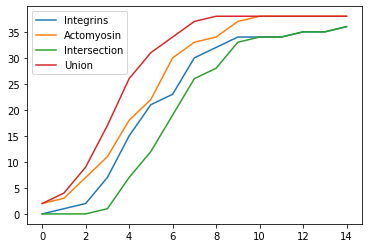

In [127]:
plt.plot(rchn_df['pathlen'], rchn_df['n_int'])
plt.plot(rchn_df['pathlen'], rchn_df['n_act'])
plt.plot(rchn_df['pathlen'], rchn_df['n_common'])
plt.plot(rchn_df['pathlen'], rchn_df["n_act"] + rchn_df["n_int"] - rchn_df['n_common'])
plt.legend(["Integrins", "Actomyosin", "Intersection", "Union"])
plt.show()

rchn_df.to_csv("Integrins+Myosin_Reached.txt", sep="\t")

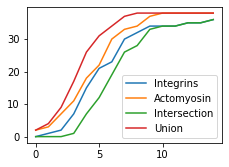

In [181]:
fig = plt.figure(figsize=[3.5,2.5])
#x = fig.add_axes([1,1,1,1])
plt.plot(rchn_df['pathlen'], rchn_df['n_int'])
plt.plot(rchn_df['pathlen'], rchn_df['n_act'])
plt.plot(rchn_df['pathlen'], rchn_df['n_common'])
plt.plot(rchn_df['pathlen'], rchn_df["n_act"] + rchn_df["n_int"] - rchn_df['n_common'])
plt.legend(["Integrins", "Actomyosin", "Intersection", "Union"])

plt.savefig('nreachable_allacto.png', dpi=600)

In [147]:
int_p5_tar = get_reached(augmented_forest_val_acto, integrins, 5).intersection(alltars)

act_p5_tar = get_reached(augmented_forest_val_acto, all_actomyosin, 5).intersection(alltars)

#nx.shortest_paths(augmented_forest_val_acto,list(integrins)[0],list(int_p5_tar)[0])
# nx.shortest_paths(augmented_forest_val_acto,"ITGAV","ACTN2")
# nx.shortest_path(G = augmented_forest_val_acto, source=integrins)
from collections import defaultdict
edge_types = defaultdict(set)
node_reach = defaultdict(set)
for int_s in set(integrins).intersection(augmented_forest_val_acto.nodes()):
    for int_t in int_p5_tar:
        try:
            paths = list(nx.all_shortest_paths(G = augmented_forest_val_acto, source = int_s, target = int_t))
        except nx.exception.NetworkXNoPath:
            paths = []
        paths = list(filter(lambda x: (len(x)<=6), paths))
        for path in paths:
            n1 = path[0]
            node_reach[n1].add("int5")
            for i in range(1,len(path)):
                n2 = path[i]
                node_reach[n2].add("int5")
                edge_types[tuple(sorted((n1,n2)))].add("int5")
                n1 = n2
                
for act_s in set(all_actomyosin).intersection(augmented_forest_val_acto.nodes()):
    for act_t in set(act_p5_tar):
        try:
            paths = list(nx.all_shortest_paths(G = augmented_forest_val_acto, source = act_s, target = act_t))
        except nx.exception.NetworkXNoPath:
            paths = []
        paths = list(filter(lambda x: (len(x)<=6), paths))
        for path in paths:
            n1 = path[0]
            node_reach[n1].add("act5")
            for i in range(1, len(path)):
                n2 = path[i]
                node_reach[n2].add("act5")
                edge_types[tuple(sorted((n1,n2)))].add("act5")
                n1 = n2
                

#nx.edge_betweenness(augmented_forest_val)
#('MYBPC3','TRIM63') in augmented_forest_val.edges()

In [149]:
for k,v in edge_types.items():
    if len(v)==2:
        edge_types[k] = "both"
    else:
        edge_types[k] = v.pop()
        
for k,v in node_reach.items():
    if len(v)==2:
        node_reach[k] = "both"
    else:
        node_reach[k] = v.pop()

In [150]:
for n1,n2 in augmented_forest_val_acto.edges():
    if tuple(sorted([n1,n2])) not in edge_types:
        edge_types[tuple(sorted([n1,n2]))] = "none"
for n1 in augmented_forest_val_acto.nodes():
    if n1 not in node_reach:
        node_reach[n1] = "none"

In [151]:
nx.set_edge_attributes(G=augmented_forest_val_acto, values=edge_types, name="pathtype")
nx.set_node_attributes(G=augmented_forest_val_acto, values=node_reach, name="nodereach")

In [182]:
nodes_df = pd.DataFrame.from_dict(dict(augmented_forest_val_acto.nodes(data=True)), orient='index')
nodes_df.to_csv("all_acto_nodes_df.txt",sep="\t")

In [158]:
nodes_df.loc[(nodes_df['nodereach']=='int5') & (nodes_df['terminal']==True)]

,prize,terminal,type,degree,betweenness,louvain_clusters,location,general_process,specific_process,general_function,specific_function,node_type,F30_N30.l2fc,nodereach
ACVR1,10.739214,True,protein,7,0.000000,5,protein complex,biological regulation,regulation of biological process,binding,protein binding,GO,0.073921,int5
AGTR2,34.484720,True,protein,2,0.000000,0,plasma_membrane,biological regulation,regulation of biological process,binding,protein binding,GO,2.448472,int5
AKAP13,19.348778,True,protein,9,0.000000,0,cytoplasm,biological regulation,regulation of biological process,binding,protein binding,GO,0.934878,int5
BMP2,10.000000,True,protein,4,0.000000,5,plasma_membrane,biological regulation,regulation of biological process,binding,protein binding,GO,-2.475466,int5
BMP4,10.000000,True,protein,3,0.000000,5,extracellular,biological regulation,regulation of biological process,binding,protein binding,GO,-1.291934,int5
GATA4,10.000000,True,protein,9,0.028976,5,nucleus,developmental process,anatomical structure development,binding,protein binding,GO,-0.085185,int5
ITGA1,300.000000,True,protein,3,0.000000,0,plasma_membrane,biological regulation,regulation of biological process,binding,protein binding,integrin,-1.407554,int5
ITGAV,300.000000,True,protein,6,0.000000,0,plasma_membrane,biological regulation,regulation of biological process,binding,protein binding,integrin,-0.050435,int5
MEF2C,11.347839,True,protein,9,0.098911,6,nucleus,biological regulation,regulation of biological process,binding,protein binding,GO,0.134784,int5
MYOCD,15.658527,True,protein,5,0.000000,5,nucleus,biological regulation,regulation of biological process,binding,protein binding,GO,0.565853,int5


In [191]:
", ".join(nodes_df.loc[(nodes_df['nodereach']=='act5') & (nodes_df['terminal']==True)].index.values.tolist())

'ACO1, ADRA1A, AKAP6, APOBEC3G, CDK1, DDX39B, IGF1, IREB2, KHDRBS1, KHDRBS3, LIN28A, LIN28B, MYL2, NCBP2, NIFK, NUDT21, RBM15, RBM15B, RBMX, RNPS1, SAMHD1, SGCD, SRSF1, SRSF6, WT1, YBX1, YTHDC1'

In [192]:
", ".join(nodes_df.loc[(nodes_df['nodereach']=='int5') & (nodes_df['terminal']==True)].index.values.tolist())

'ACVR1, AGTR2, AKAP13, BMP2, BMP4, GATA4, ITGA1, ITGAV, MEF2C, MYOCD, NKX2-5'

In [193]:
", ".join(nodes_df.loc[(nodes_df['nodereach']=='both') & (nodes_df['terminal']==True)].index.values.tolist())

'ACTN2, CAV3, FHL2, GSK3A, ITGB1, MYBPC1, MYBPC3, NEB, SORBS2, SRF, TCAP, TTN'